In [2]:
# IMPORT NECESSARY LIBRARIES
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.models import Sequential, load_model
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import soundfile as sf
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense, LSTM
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
seed=7
np.random.seed(seed)
from matplotlib.pyplot import specgram
import glob 
import IPython.display as ipd  # To play sound in the notebook
import pickle
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
EMO = "/content/drive/MyDrive/Emo-db/"
# Run one example 
dir_list = os.listdir(EMO)
dir_list[0:5]

['08a01Na.wav', '03a01Nc.wav', '08a01Wc.wav', '09a01Fa.wav', '08a01Fd.wav']

In [ ]:

# Get the data location for EMO
dir_list = os.listdir(EMO)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if  (i[-6:-5]=='W') or (i[-6:-5]=='E') :
        emotion.append('Angry')
    elif i[-6:-5]=='F':
        emotion.append('Happy')
    elif (i[-6:-5]=='L') or (i[-6:-5]=='T'):
        emotion.append('Sad')
    elif i[-6:-5]=='A':
        emotion.append('Fear')
    elif i[-6:-5]=='N':
        emotion.append('Neutral')
    else:
        emotion.append('Unknown') 
    path.append(EMO + i)

# Now check out the label count distribution 
EMO_df = pd.DataFrame(emotion, columns = ['emotion'])
EMO_df['source'] = 'EMO'
EMO_df = pd.concat([EMO_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
EMO_df.emotion.value_counts()


Angry      173
Sad        143
Neutral     79
Happy       71
Fear        69
Name: emotion, dtype: int64

In [4]:
# Get the data location for EMO
dir_list = os.listdir(EMO)

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if  (i[-6:-5]=='W') :
        emotion.append('Angry')
    elif (i[-6:-5]=='E') :
        emotion.append('Disgust')    
    elif i[-6:-5]=='F':
        emotion.append('Happy')
    elif (i[-6:-5]=='L') :
        emotion.append('Boredom')
    elif (i[-6:-5]=='T') :
        emotion.append('Sadness') 
    elif i[-6:-5]=='A':
        emotion.append('Fear')
    elif i[-6:-5]=='N':
        emotion.append('Neutral')
    else:
        emotion.append('Unknown') 
    path.append(EMO + i)

# Now check out the label count distribution 
EMO_df = pd.DataFrame(emotion, columns = ['emotion'])
EMO_df['source'] = 'EMO'
EMO_df = pd.concat([EMO_df, pd.DataFrame(path, columns = ['path'])], axis = 1)
EMO_df.emotion.value_counts()


Angry      127
Boredom     81
Neutral     79
Happy       71
Fear        69
Sadness     62
Disgust     46
Name: emotion, dtype: int64

In [5]:
df = pd.concat([EMO_df], axis = 0)
print(df.emotion.value_counts())
df.head()
df.to_csv("Data_path.csv",index=False)

Angry      127
Boredom     81
Neutral     79
Happy       71
Fear        69
Sadness     62
Disgust     46
Name: emotion, dtype: int64


In [7]:
# lets pick up the meta-data that we got from our first part of the Kernel
ref = pd.read_csv("./Data_path.csv")
ref.head(10)

emotion source                                       path
0  Neutral    EMO  /content/drive/MyDrive/Emo-db/08a01Na.wav
1  Neutral    EMO  /content/drive/MyDrive/Emo-db/03a01Nc.wav
2    Angry    EMO  /content/drive/MyDrive/Emo-db/08a01Wc.wav
3    Happy    EMO  /content/drive/MyDrive/Emo-db/09a01Fa.wav
4    Happy    EMO  /content/drive/MyDrive/Emo-db/08a01Fd.wav
5    Angry    EMO  /content/drive/MyDrive/Emo-db/03a01Wa.wav
6     Fear    EMO  /content/drive/MyDrive/Emo-db/08a01Ab.wav
7    Angry    EMO  /content/drive/MyDrive/Emo-db/08a01Wa.wav
8  Boredom    EMO  /content/drive/MyDrive/Emo-db/08a01Lc.wav
9    Happy    EMO  /content/drive/MyDrive/Emo-db/12a01Fb.wav

In [8]:
# ENSURE GENDER,EMOTION, AND ACTOR COLUMN VALUES ARE CORRECT
pd.set_option('display.max_colwidth', -1)
df.sample(100)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


emotion source                                       path
458  Fear     EMO    /content/drive/MyDrive/Emo-db/12b10Ac.wav
235  Sadness  EMO    /content/drive/MyDrive/Emo-db/10a07Ta.wav
281  Happy    EMO    /content/drive/MyDrive/Emo-db/08b02Ff.wav
55   Angry    EMO    /content/drive/MyDrive/Emo-db/03a02Wc.wav
284  Boredom  EMO    /content/drive/MyDrive/Emo-db/03b02La.wav
..       ...  ...                                          ...
60   Neutral  EMO    /content/drive/MyDrive/Emo-db/16a02Nb.wav
452  Sadness  EMO    /content/drive/MyDrive/Emo-db/11b10Td.wav
204  Boredom  EMO    /content/drive/MyDrive/Emo-db/15a05Lb.wav
371  Angry    EMO    /content/drive/MyDrive/Emo-db/15b03Wa.wav
164  Angry    EMO    /content/drive/MyDrive/Emo-db/03a05Wa.wav

[100 rows x 3 columns]

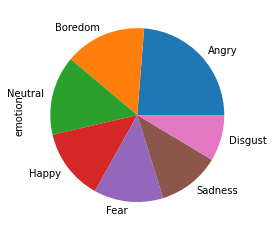

In [9]:
# LOOK AT DISTRIBUTION OF CLASSES
df.emotion.value_counts().plot(kind='pie') 

In [ ]:
# Note this takes a couple of minutes (~10 mins) as we're iterating over 4 datasets 
df = pd.DataFrame(columns=['Features'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  ,res_type='kaiser_fast'
                                  ,duration=3
                                  ,sr=44100
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    result = np.array([])
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=20),
                    axis=0)
    result=np.hstack((result, mfccs)) # stacking horizontally

    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
    result=np.hstack((result, log_spectrogram)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(X))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=X).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    df.loc[counter] = [result]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(df))
df.head()

KeyboardInterrupt: ignored

In [ ]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df['Features'].values.tolist())],axis=1)
df[:5]

emotion source  ... 529  530
0  Fear     EMO    ... NaN NaN 
1  Happy    EMO    ... NaN NaN 
2  Happy    EMO    ... NaN NaN 
3  Happy    EMO    ... NaN NaN 
4  Neutral  EMO    ... NaN NaN 

[5 rows x 534 columns]

In [ ]:
# replace NA with 0
df=df.fillna(0)
print(df.shape)
df[:5]

(535, 534)


emotion source  ...  529  530
0  Fear     EMO    ...  0.0  0.0
1  Happy    EMO    ...  0.0  0.0
2  Happy    EMO    ...  0.0  0.0
3  Happy    EMO    ...  0.0  0.0
4  Neutral  EMO    ...  0.0  0.0

[5 rows x 534 columns]

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','emotion','source'],axis=1)
                                                    , df.emotion
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

0          1          2  ...       528       529       530
441  2.554508   0.332811  -4.323872   ...  0.000000  0.000000  0.000000
321  2.089165  -0.869029  -9.188924   ...  0.529884  0.498665  0.157187
417 -2.934747  -5.843897  -13.098154  ...  0.000000  0.000000  0.000000
297 -5.609528  -7.312801  -14.232816  ...  0.000000  0.000000  0.000000
36   2.553626   1.221201  -1.486665   ...  0.000000  0.000000  0.000000
139  0.272326   0.731354   0.041833   ...  0.000000  0.000000  0.000000
253  6.090459   3.884537   0.801549   ...  0.000000  0.000000  0.000000
519 -0.872542  -3.909370  -8.832712   ...  0.000000  0.000000  0.000000
59   0.303354  -1.409928  -2.298852   ...  0.000000  0.000000  0.000000
111 -21.578802 -16.321423 -14.244370  ...  0.000000  0.000000  0.000000

[10 rows x 531 columns]

In [ ]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

[[1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]
(428, 531, 1)
(107, 531, 1)


In [ ]:
lb.classes_

array(['Angry', 'Fear', 'Happy', 'Neutral', 'Sad'], dtype=object)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(X_train,y_train, batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 531, 256)          2304      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 524, 256)          524544    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 262, 256)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 262, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 262, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 262, 256)          524544    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 131, 256)          0

4/4 [==============================] - 0s 14ms/step - loss: 3.4769 - accuracy: 0.5794
Loss of the model is -  3.4769375324249268
4/4 [==============================] - 0s 14ms/step - loss: 3.4769 - accuracy: 0.5794
Accuracy of the model is -  57.94392228126526 %


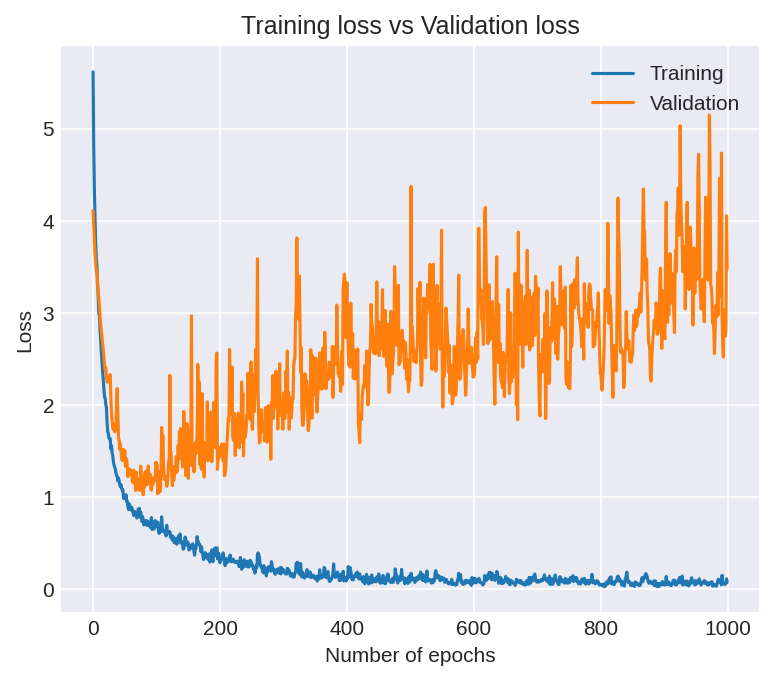

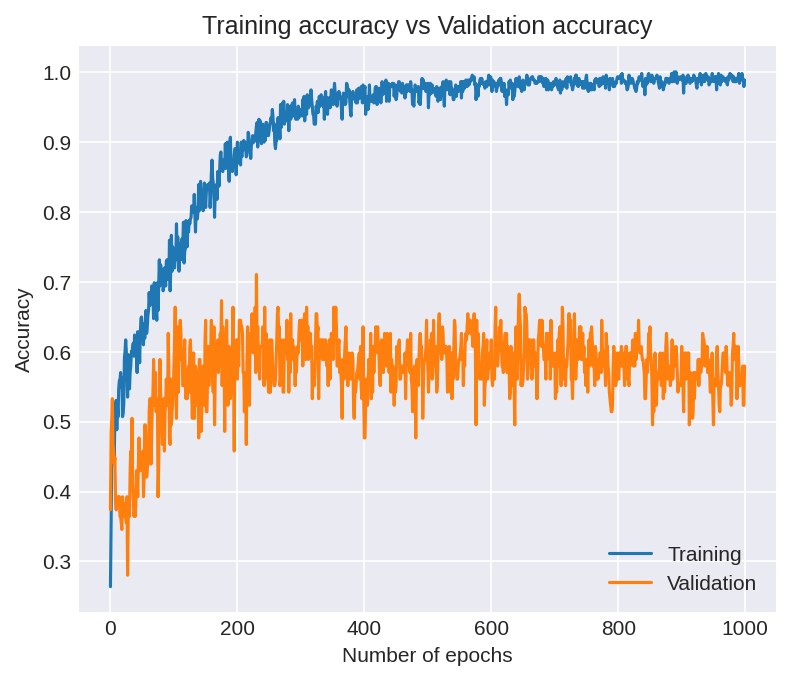

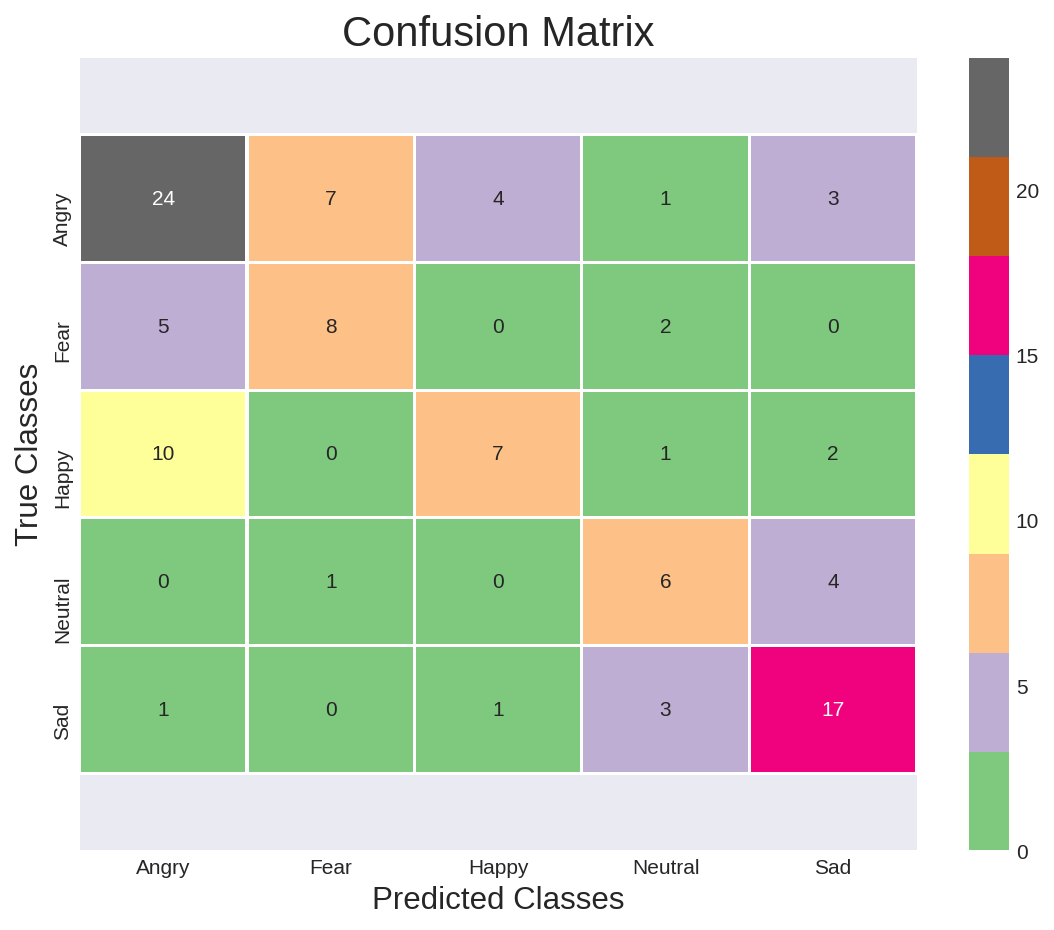

              precision    recall  f1-score   support

       Angry       0.60      0.62      0.61        39
        Fear       0.50      0.53      0.52        15
       Happy       0.58      0.35      0.44        20
     Neutral       0.46      0.55      0.50        11
         Sad       0.65      0.77      0.71        22

    accuracy                           0.58       107
   macro avg       0.56      0.56      0.55       107
weighted avg       0.58      0.58      0.57       107



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(6,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(6,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])     
# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(X_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[40:50] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9, 7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()   
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']))

In [ ]:
# ITERATE OVER ALL AUDIO FILES AND EXTRACT LOG MEL SPECTROGRAM MEAN VALUES INTO DF FOR MODELING
import pandas as pd 
df_mel = pd.DataFrame(columns=['mel_spectrogram'])

counter=0

for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=3,sr=44100,offset=0.5)
    
    #get the mel-scaled spectrogram (ransform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is kinda the log scale of amplitudes.)
    spectrogram = librosa.feature.melspectrogram(y=X, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    #temporally average spectrogram
    log_spectrogram = np.mean(db_spec, axis = 0)
        
    # Mel-frequency cepstral coefficients (MFCCs)
#     mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#     mfcc=np.mean(mfcc,axis=0)
    
    # compute chroma energy (pertains to 12 different pitch classes)
#     chroma = librosa.feature.chroma_stft(y=X, sr=sample_rate)
#     chroma = np.mean(chroma, axis = 0)

    # compute spectral contrast
#     contrast = librosa.feature.spectral_contrast(y=X, sr=sample_rate)
#     contrast = np.mean(contrast, axis= 0)

    # compute zero-crossing-rate (zcr:the zcr is the rate of sign changes along a signal i.e.m the rate at 
#     which the signal changes from positive to negative or back - separation of voiced andunvoiced speech.)
#     zcr = librosa.feature.zero_crossing_rate(y=X)
#     zcr = np.mean(zcr, axis= 0)
    
    df_mel.loc[counter] = [log_spectrogram]
    counter=counter+1   

print(len(df_mel))
df_mel.head()

535


mel_spectrogram
0  [-18.804665, -21.521597, -27.88592, -24.218561...
1  [-32.407764, -32.98968, -31.687258, -31.718386...
2  [-36.368206, -32.799015, -33.12451, -35.60933,...
3  [-46.121796, -42.230083, -31.603167, -25.71852...
4  [-14.672596, -17.095194, -24.047354, -28.71509...

In [ ]:
# Now extract the mean bands to its own feature columns
df = pd.concat([ref,pd.DataFrame(df_mel['mel_spectrogram'].values.tolist())],axis=1)
df[:5]

labels source  ... 257  258
0     Fear    EMO  ... NaN  NaN
1    Happy    EMO  ... NaN  NaN
2    Happy    EMO  ... NaN  NaN
3    Happy    EMO  ... NaN  NaN
4  Neutral    EMO  ... NaN  NaN

[5 rows x 262 columns]

In [ ]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(df.drop(['path','labels','source'],axis=1)
                                                    , df.labels
                                                    , test_size=0.20
                                                    , shuffle=True
                                                    , random_state=42
                                                   )

# Lets see how the data present itself before normalisation 
X_train[150:160]

0          1          2    ...        256        257        258
441 -13.191162 -17.412943 -24.742369  ...        NaN        NaN        NaN
321  -1.592765  -2.214412  -4.411089  ... -17.715269 -15.240993 -13.151398
417 -12.716684 -15.351578 -24.829851  ...        NaN        NaN        NaN
297 -20.364967 -18.610880 -17.983961  ...        NaN        NaN        NaN
36  -11.744615 -12.375156 -14.608455  ...        NaN        NaN        NaN
139  -6.723027  -8.061245 -10.093167  ...        NaN        NaN        NaN
253  -9.062586 -12.493947 -18.453823  ...        NaN        NaN        NaN
519 -10.904872 -13.345657 -17.893707  ...        NaN        NaN        NaN
59  -14.477571 -16.002350 -18.644583  ...        NaN        NaN        NaN
111 -42.475464 -28.780304 -22.017761  ...        NaN        NaN        NaN

[10 rows x 259 columns]

In [ ]:

# NORMALIZE DATA
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
# TURN DATA INTO ARRAYS FOR KERAS
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
X_train = X_train[:,:,np.newaxis]
X_test = X_test[:,:,np.newaxis]

print(X_train.shape)
print(X_test.shape)

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]
(428, 259, 1)
(107, 259, 1)


In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(X_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.001), bias_regularizer=l2(0.001)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(X_train,y_train, batch_size=32, epochs=1000, validation_data=(X_test, y_test),callbacks=[checkpoint])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 345, 256)          2304      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 338, 256)          524544    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 169, 256)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 169, 256)          1024      
_________________________________________________________________
dropout (Dropout)            (None, 169, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 169, 256)          524544    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 84, 256)           0

In [10]:
data_path = pd.concat([df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head()

emotion source                                       path
0  Neutral  EMO    /content/drive/MyDrive/Emo-db/08a01Na.wav
1  Neutral  EMO    /content/drive/MyDrive/Emo-db/03a01Nc.wav
2  Angry    EMO    /content/drive/MyDrive/Emo-db/08a01Wc.wav
3  Happy    EMO    /content/drive/MyDrive/Emo-db/09a01Fa.wav
4  Happy    EMO    /content/drive/MyDrive/Emo-db/08a01Fd.wav

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


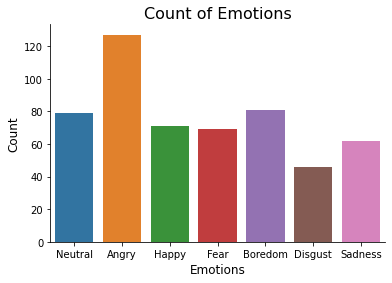

In [11]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show() 

In [31]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [30]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [33]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
       
    return result

In [34]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [35]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [36]:
len(X), len(Y), data_path.path.shape

(1605, 1605, (535,))

In [37]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2  ...           153           154   labels
0  0.085162  0.574001  0.659725  ...  2.330531e-07  2.296988e-07  Neutral
1  0.165853  0.610366  0.691435  ...  2.015192e-03  1.951354e-03  Neutral
2  0.099811  0.560870  0.620877  ...  1.321567e-07  9.524816e-08  Neutral
3  0.084861  0.643669  0.576430  ...  1.780936e-09  1.750581e-09  Neutral
4  0.292669  0.769387  0.756605  ...  3.431972e-02  3.165534e-02  Neutral

[5 rows x 156 columns]

In [38]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape

[[0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]]
(1284, 155, 1)
(321, 155, 1)


(1605, 7)

In [39]:
lb.classes_

array(['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral',
       'Sadness'], dtype=object)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_16 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 37, 256)          

11/11 [==============================] - 0s 7ms/step - loss: 0.4898 - accuracy: 0.9283
Loss of the model is -  0.48982158303260803
11/11 [==============================] - 0s 7ms/step - loss: 0.4898 - accuracy: 0.9283
Accuracy of the model is -  92.83488988876343 %


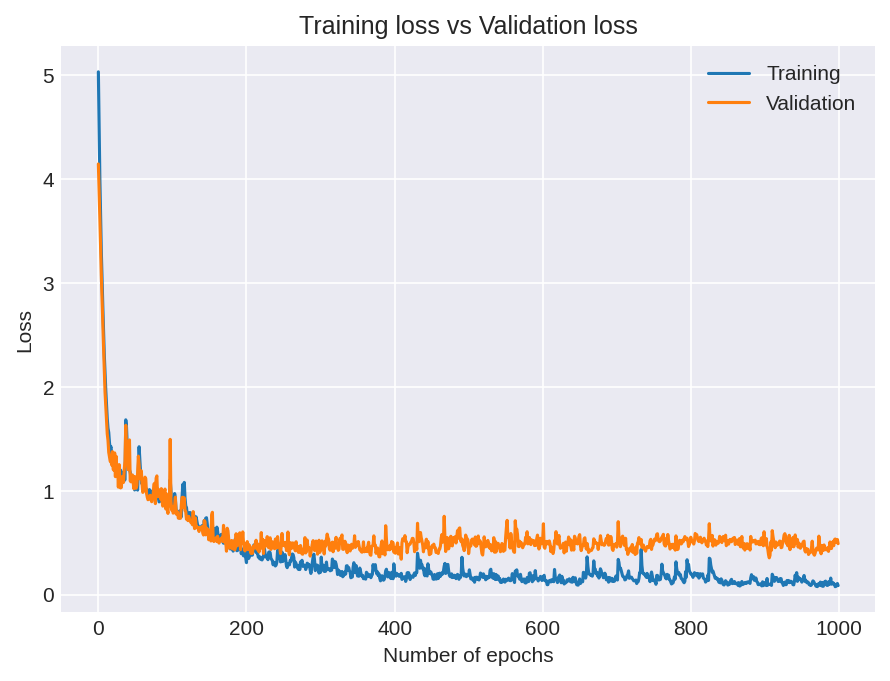

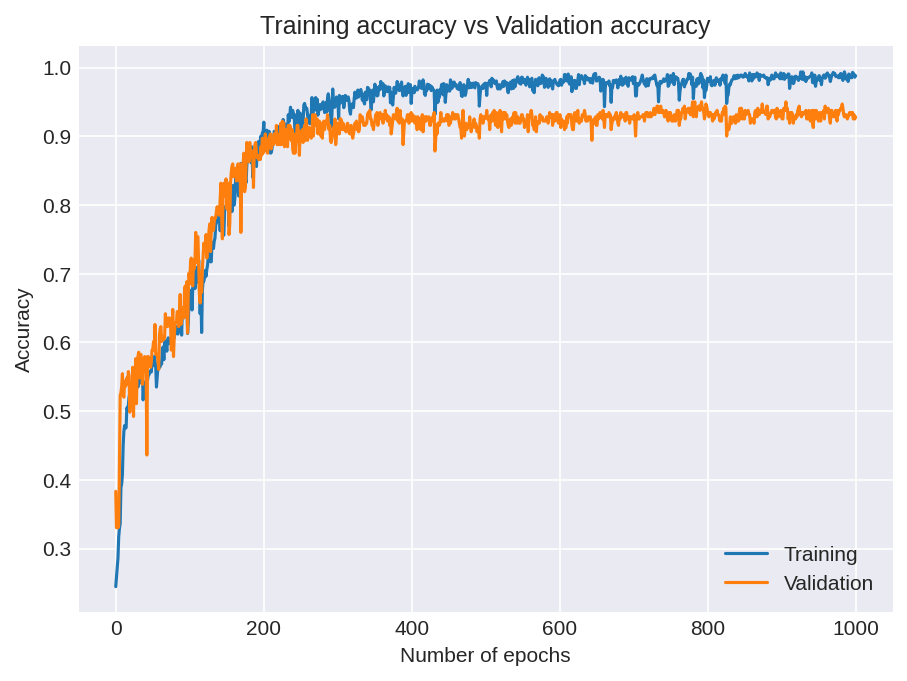

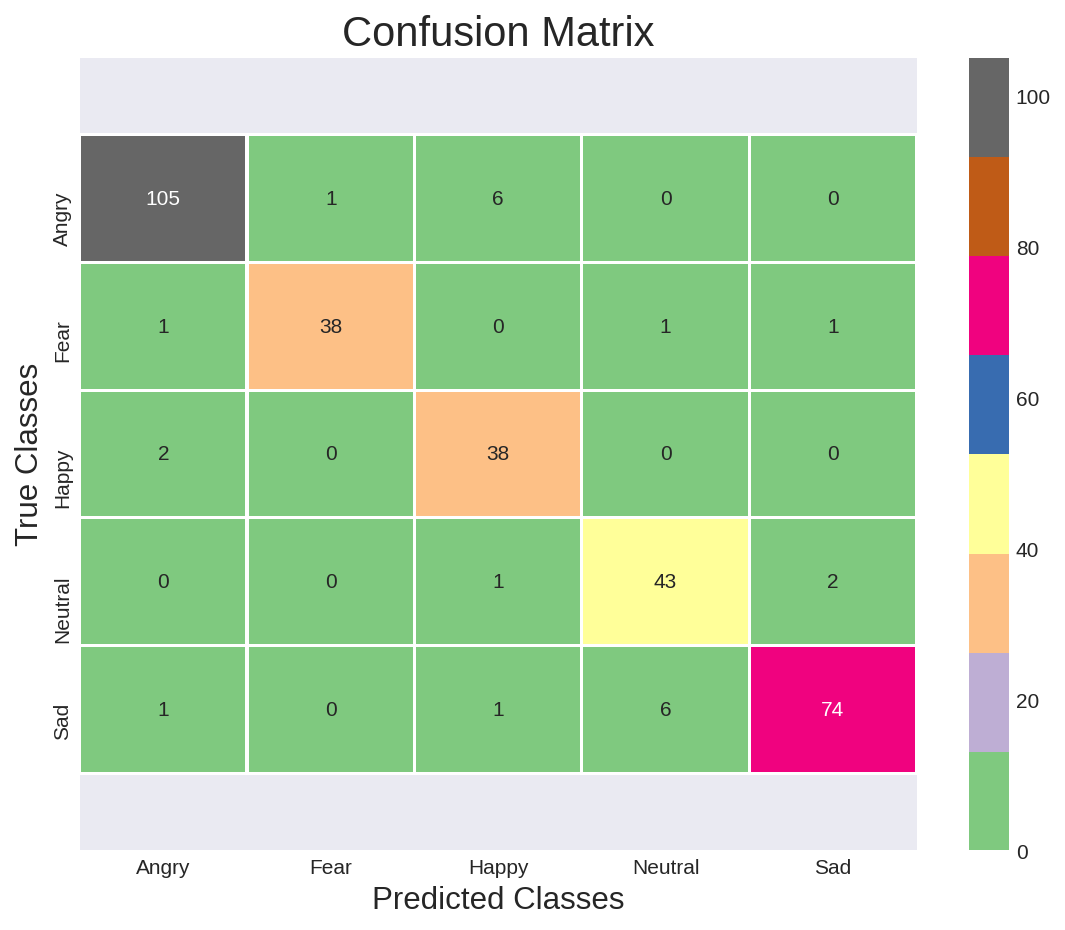

              precision    recall  f1-score   support

       Angry       0.96      0.94      0.95       112
        Fear       0.97      0.93      0.95        41
       Happy       0.83      0.95      0.88        40
     Neutral       0.86      0.93      0.90        46
         Sad       0.96      0.90      0.93        82

    accuracy                           0.93       321
   macro avg       0.92      0.93      0.92       321
weighted avg       0.93      0.93      0.93       321



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']))

In [ ]:
#Accuarte class labels

In [ ]:
data_path = pd.concat([df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path.head(50)

emotion  ...                                                               path
0   Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/08a01Ab.wav
1   Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/12a01Fb.wav
2   Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/03a01Fa.wav
3   Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/09a01Fa.wav
4   Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/08a01Na.wav
5   Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/08a01Wa.wav
6   Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Fd.wav
7   Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/03a01Nc.wav
8   Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/08a01Wc.wav
9   Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/08a01Fd.wav
10  Boredom  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/08a01Lc.wav
11  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/03a01Wa.wav
12  Disgust  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Ea.wav
13  Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/11a01Ab.wav
14  Boredom  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/11a01Ld.wav
15  Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/16a01Fc.wav
16  Boredom  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/12a01Lb.wav
17  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/09a01Nb.wav
18  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/12a01Wc.wav
19  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/11a01Wc.wav
20  Happy    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/15a01Fb.wav
21  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/10a01Wa.wav
22  Disgust  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Ec.wav
23  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/10a01Nb.wav
24  Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Ac.wav
25  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/12a01Nb.wav
26  Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/10a01Ac.wav
27  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/11a01Nd.wav
28  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/09a01Wb.wav
29  Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/11a01Aa.wav
30  Disgust  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/09a01Ea.wav
31  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Wb.wav
32  Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/14a01Ac.wav
33  Fear     ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/14a01Aa.wav
34  Sadness  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/16a01Tb.wav
35  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/14a01Wa.wav
36  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/15a01Nb.wav
37  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/15a01Wa.wav
38  Disgust  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/14a01Ea.wav
39  Boredom  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/15a01La.wav
40  Angry    ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/16a01Wb.wav
41  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Nb.wav
42  Boredom  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/13a01Lb.wav
43  Disgust  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/15a01Ea.wav
44  Disgust  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/16a01Ec.wav
45  Neutral  ...  /content/drive/MyDrive/Speech Emotion analysis/Emo-db/14a01Na.wav
46  Boredom  ...  /content/drive/MyDrive/Speech Emotion 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


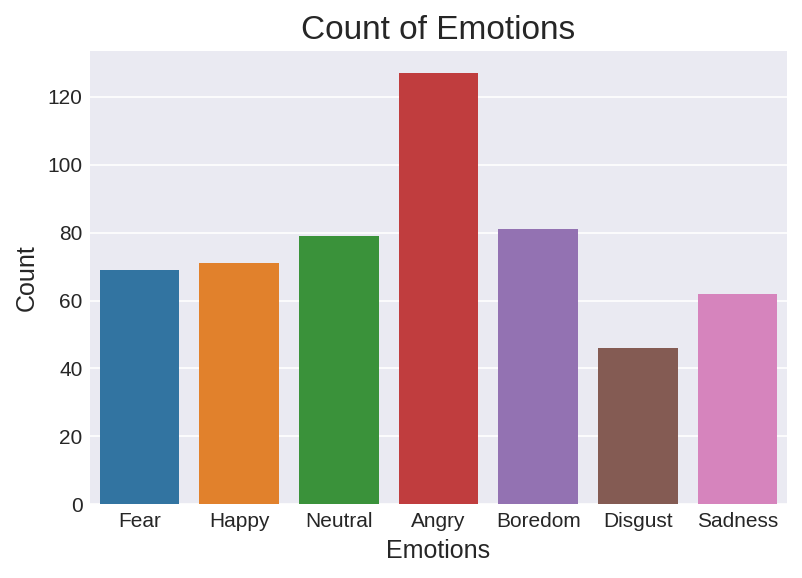

In [ ]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.emotion)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show() 

In [ ]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [ ]:
def noise(data):
    noise_amp = 0.015*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def pitch2(data, sampling_rate, pitch_factor=0.6):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.path)[1]
data, sample_rate = librosa.load(path)

In [ ]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
       
    return result

In [ ]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    result = np.array([])
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically

    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch2(new_data, sample_rate)
    res4 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res4)) # stacking vertically
    
    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(df.path, df.emotion):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.path.shape

(2140, 2140, (535,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

0         1         2         3  ...       152       153       154  labels
0  0.118058  0.565005  0.608090  0.683121  ...  0.000002  0.000002  0.000002  Fear  
1  0.159499  0.573767  0.600857  0.691580  ...  0.000170  0.000166  0.000172  Fear  
2  0.129947  0.479741  0.530497  0.620380  ...  0.000004  0.000006  0.000007  Fear  
3  0.128188  0.508703  0.586469  0.702197  ...  0.000003  0.000005  0.000007  Fear  
4  0.090625  0.486378  0.538183  0.593669  ...  0.000002  0.000002  0.000002  Happy 

[5 rows x 156 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

X = Features.iloc[: ,:-1].values
Y = Features['labels'].values
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size=0.20, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

# NORMALIZE DATA
mean = np.mean(x_train, axis=0)
std = np.std(x_train, axis=0)
x_train = (x_train - mean)/std
x_test = (x_test - mean)/std

# TURN DATA INTO ARRAYS FOR KERAS
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
# ONE HOT ENCODE THE TARGET
# CNN REQUIRES INPUT AND OUTPUT ARE NUMBERS
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(y_train))
y_test = to_categorical(lb.fit_transform(y_test))
print(y_test[0:10])
# RESHAPE DATA TO INCLUDE 3D TENSOR 
x_train = x_train[:,:,np.newaxis]
x_test = x_test[:,:,np.newaxis]

print(x_train.shape)
print(x_test.shape)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=2, shuffle=True)
acc_per_fold = []
loss_per_fold = []
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
inputs.shape
targets.shape



[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]
(1712, 155, 1)
(428, 155, 1)


(2140, 7)

In [ ]:
lb.classes_

array(['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral',
       'Sadness'], dtype=object)

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_31 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_34 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 37, 256)          

11/11 [==============================] - 0s 7ms/step - loss: 0.6304 - accuracy: 0.8442
Loss of the model is -  0.6303622722625732
11/11 [==============================] - 0s 6ms/step - loss: 0.6304 - accuracy: 0.8442
Accuracy of the model is -  84.42367315292358 %


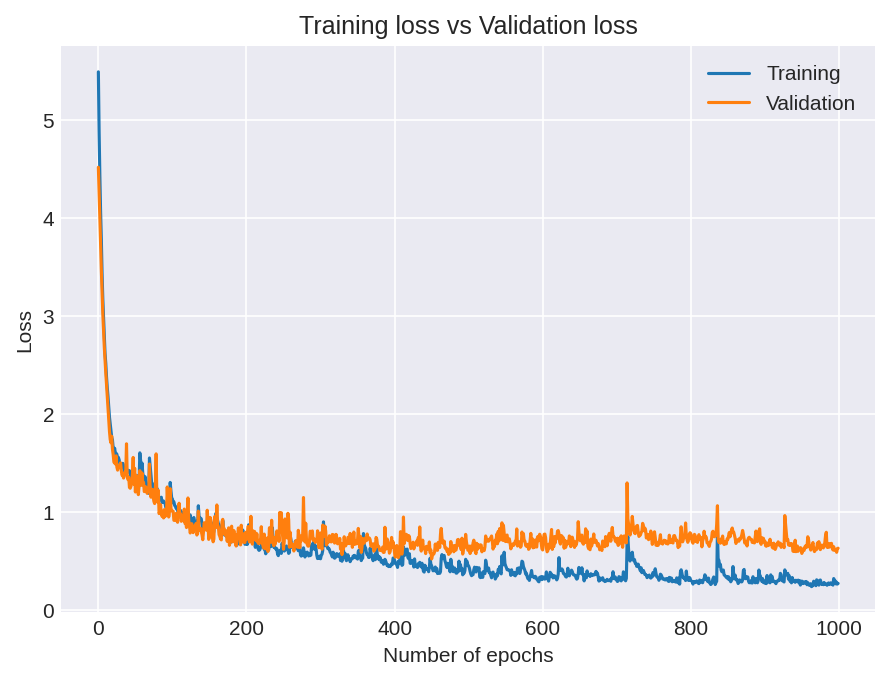

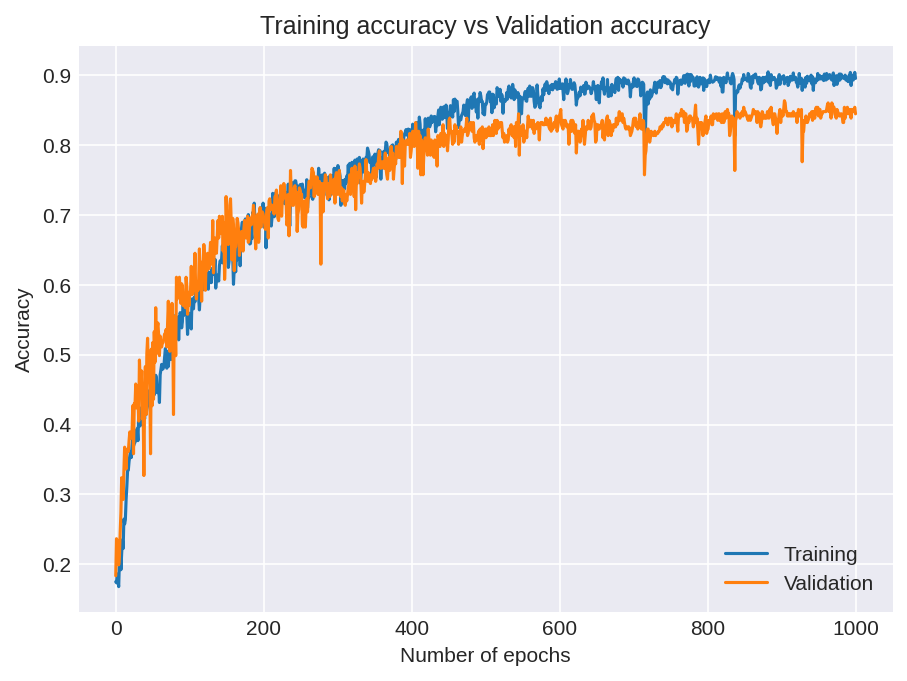

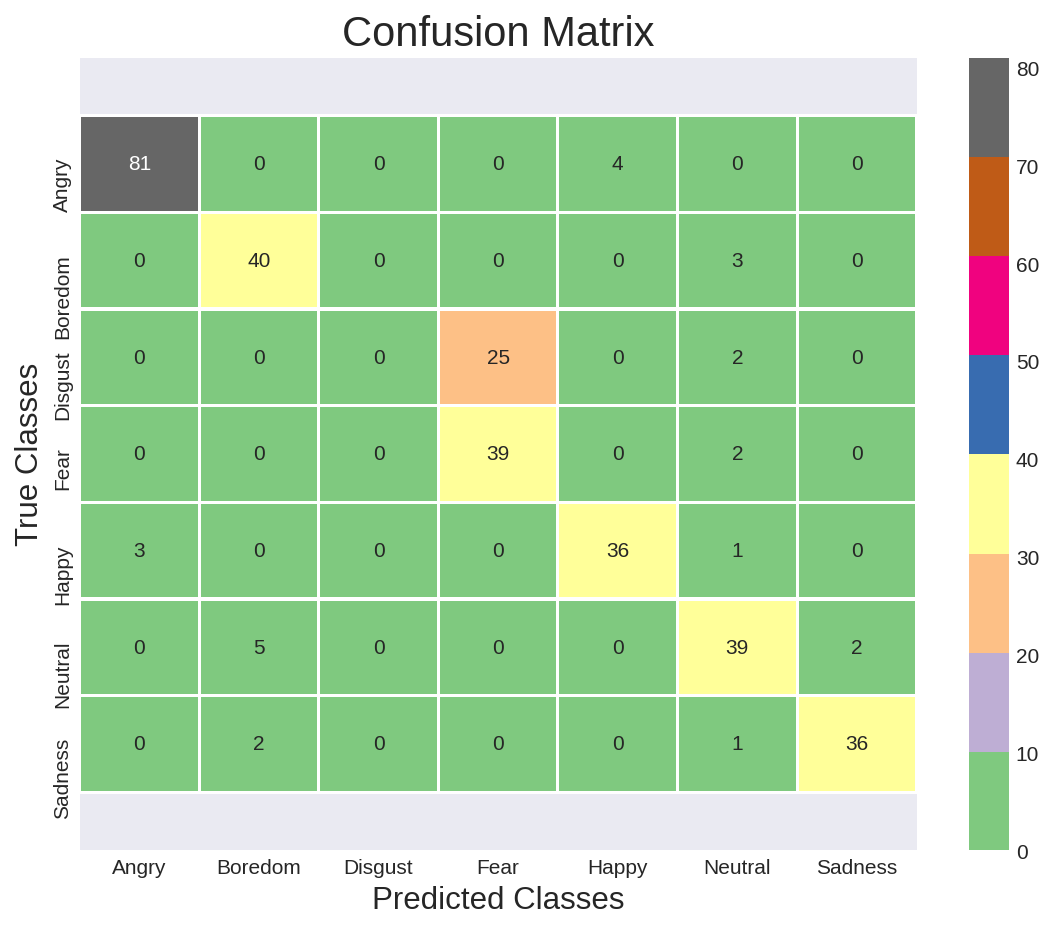

              precision    recall  f1-score   support

       Angry       0.96      0.95      0.96        85
     Boredom       0.85      0.93      0.89        43
     Disgust       0.00      0.00      0.00        27
        Fear       0.61      0.95      0.74        41
       Happy       0.90      0.90      0.90        40
     Neutral       0.81      0.85      0.83        46
     Sadness       0.95      0.92      0.94        39

    accuracy                           0.84       321
   macro avg       0.73      0.79      0.75       321
weighted avg       0.79      0.84      0.81       321



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 150 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('Initial_Model_Confusion_Matrix-SGD-SPECTROGRAM.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [ ]:
model = tf.keras.Sequential()
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model.add(layers.MaxPooling1D(pool_size=(2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_39 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_43 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 37, 256)          

14/14 [==============================] - 0s 7ms/step - loss: 0.1976 - accuracy: 0.9860
Loss of the model is -  0.1976107954978943
14/14 [==============================] - 0s 7ms/step - loss: 0.1976 - accuracy: 0.9860
Accuracy of the model is -  98.5981285572052 %


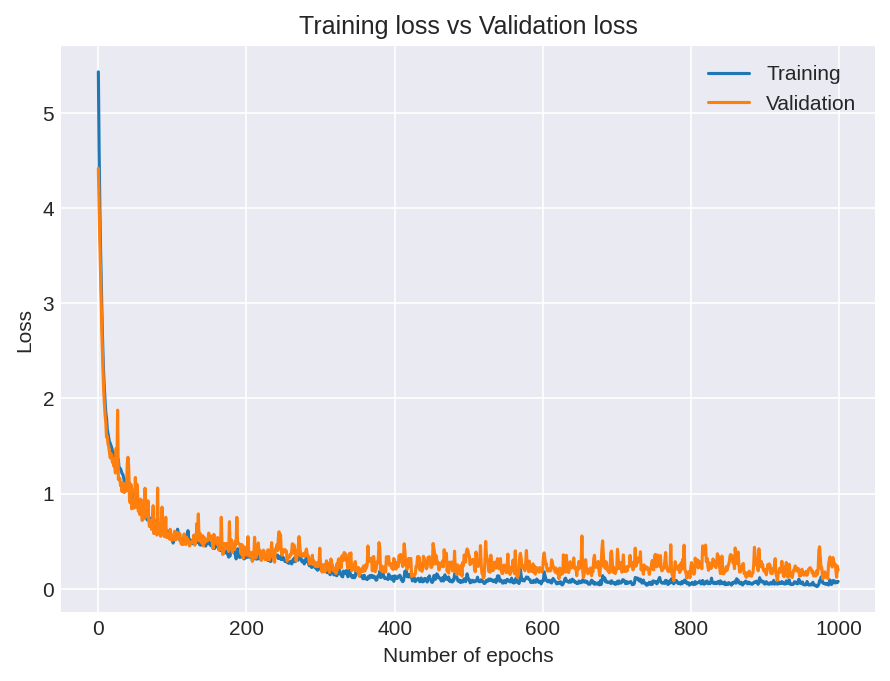

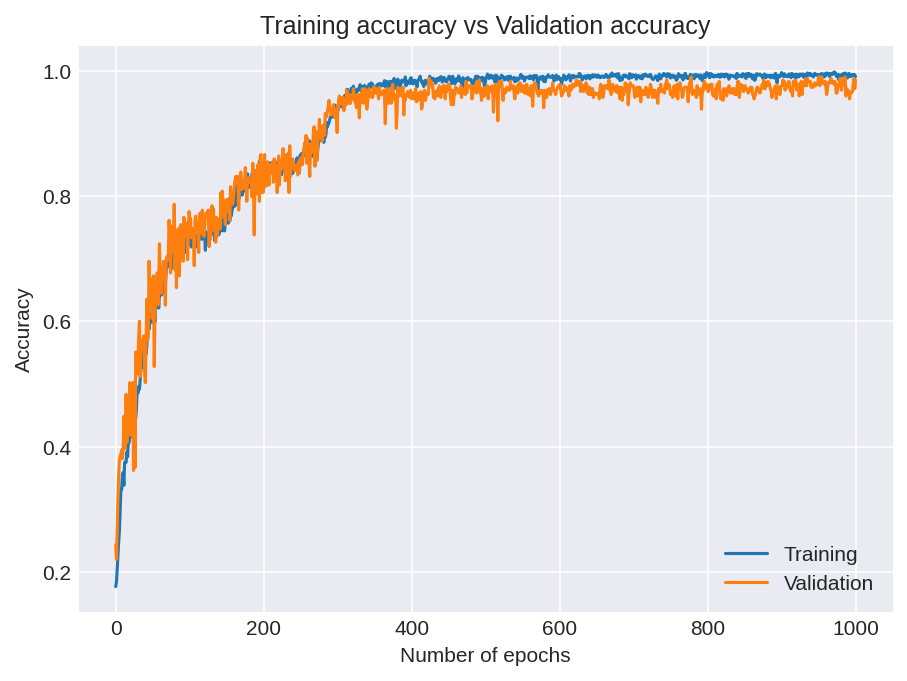

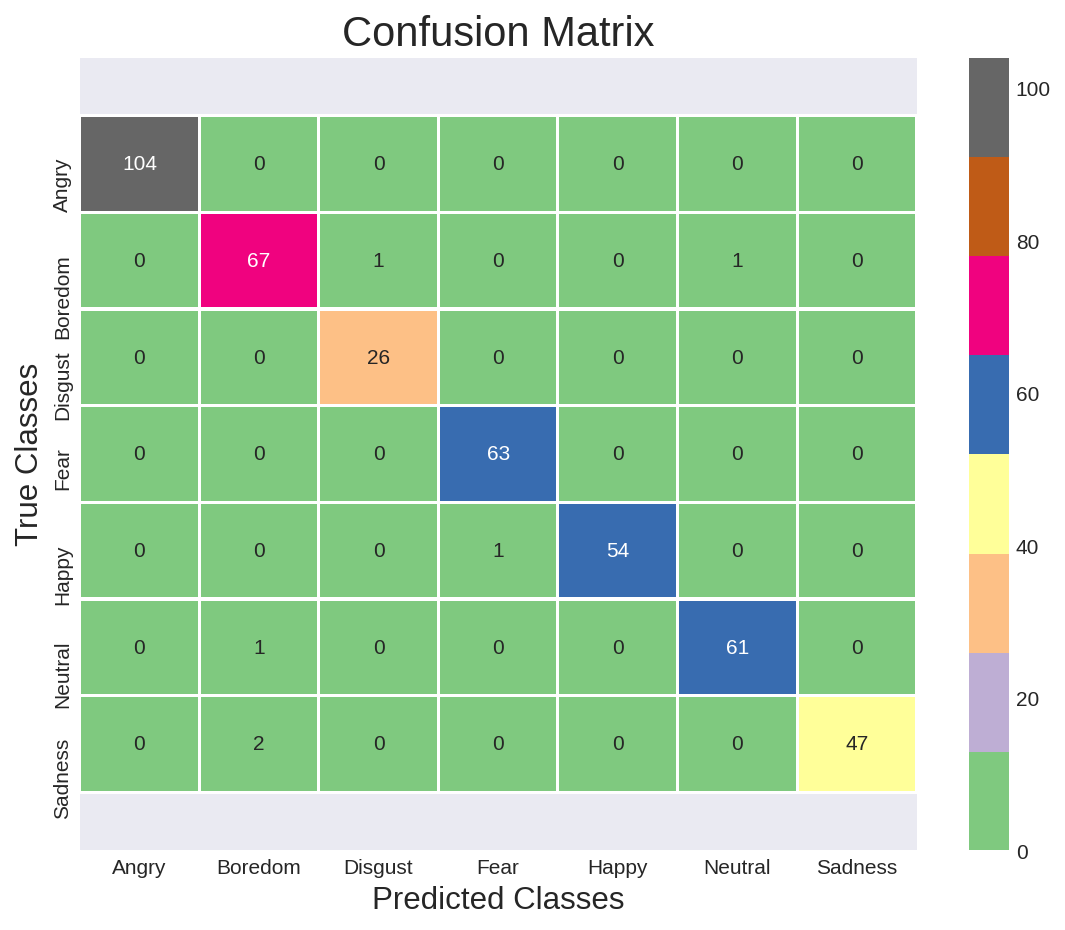

              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00       104
     Boredom       0.96      0.97      0.96        69
     Disgust       0.96      1.00      0.98        26
        Fear       0.98      1.00      0.99        63
       Happy       1.00      0.98      0.99        55
     Neutral       0.98      0.98      0.98        62
     Sadness       1.00      0.96      0.98        49

    accuracy                           0.99       428
   macro avg       0.98      0.99      0.98       428
weighted avg       0.99      0.99      0.99       428



In [ ]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [ ]:
#ENSEMBLE TECHNIQUE

In [ ]:
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.5))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(LSTM(512))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history2=model2.fit(x_train, y_train,batch_size=32, epochs=100, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('saved_models/model2.hdf5')

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_57 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_58 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_55 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_59 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 37, 256)          

In [ ]:
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_models/model1.hdf5')
model2 = load_model('saved_models/model2.hdf5')

models = [model1, model2]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict_classes(x_test)
prediction2 = model2.predict_classes(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.1, 0.9]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score for model1 =  0.8255451713395638
Accuracy Score for model2 =  0.8535825545171339
Accuracy Score for average ensemble =  0.8847352024922118
Accuracy Score for model1 =  0.8255451713395638
Accuracy Score for model2 =  0.8535825545171339
Accuracy Score for average ensemble =  0.8847352024922118
Accuracy Score for weighted average ensemble =  0.8535825545171339


In [ ]:
########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
            wts = [w1/10.,w2/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1],'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[0], " obained with w1=", max_acc_row[1],
      " w2=", max_acc_row[2])

Max accuracy of  0.1  obained with w1= 0.1  w2= 88.47352024922118


In [ ]:
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.5))
model3.add(LSTM(units=512,activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(7, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history2=model3.fit(x_train, y_train,batch_size=32, epochs=100, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('saved_models/model3.hdf5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_42 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_36 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 37, 256)          

In [ ]:
#ENSEMBLE

In [25]:
#MODEL-1
model1 = tf.keras.Sequential()
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.25))
model1.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model1.add(layers.MaxPooling1D(pool_size=(2)))
model1.add(BatchNormalization())
model1.add(layers.Dropout(0.5))
model1.add(layers.Flatten())
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dropout(0.5))
model1.add(layers.Dense(7, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model1.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model1.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model1.save('saved_models/model1-emo-db.hdf5')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_38 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_29 (MaxPooling (None, 37, 256)          

11/11 [==============================] - 0s 6ms/step - loss: 0.6151 - accuracy: 0.9159
Loss of the model is -  0.6150932908058167
11/11 [==============================] - 0s 7ms/step - loss: 0.6151 - accuracy: 0.9159
Accuracy of the model is -  91.58878326416016 %


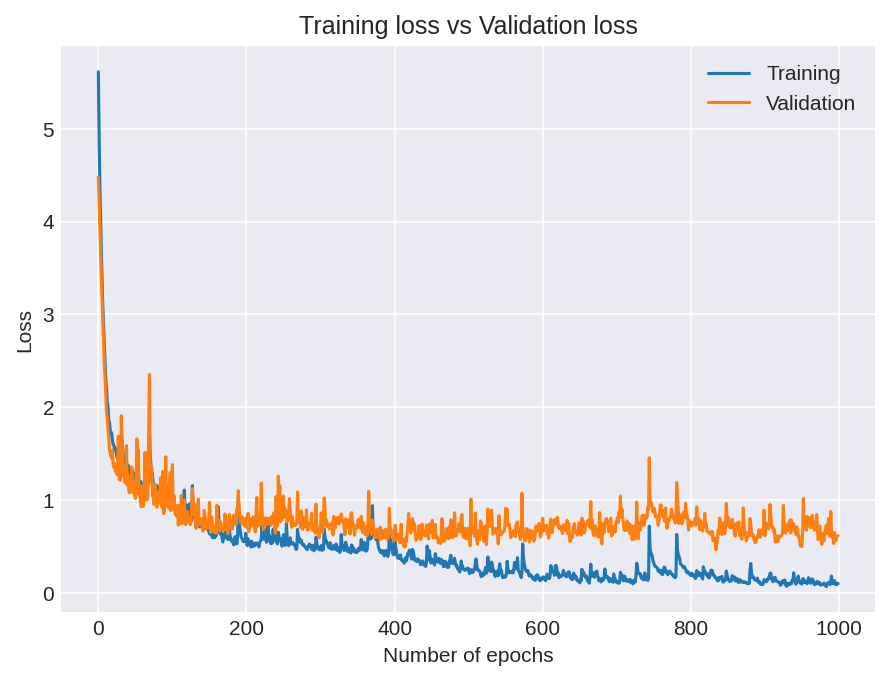

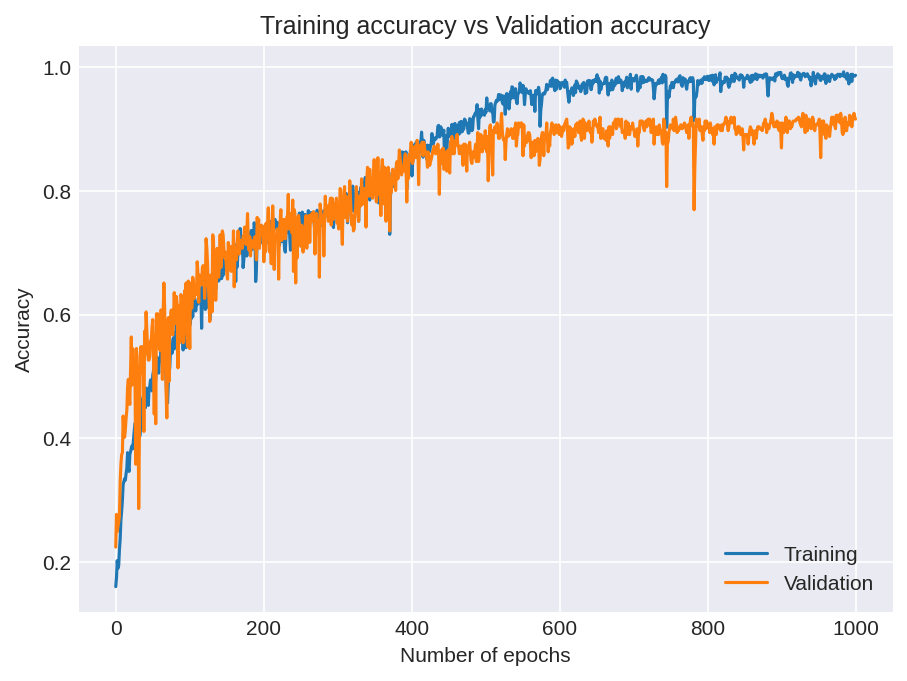

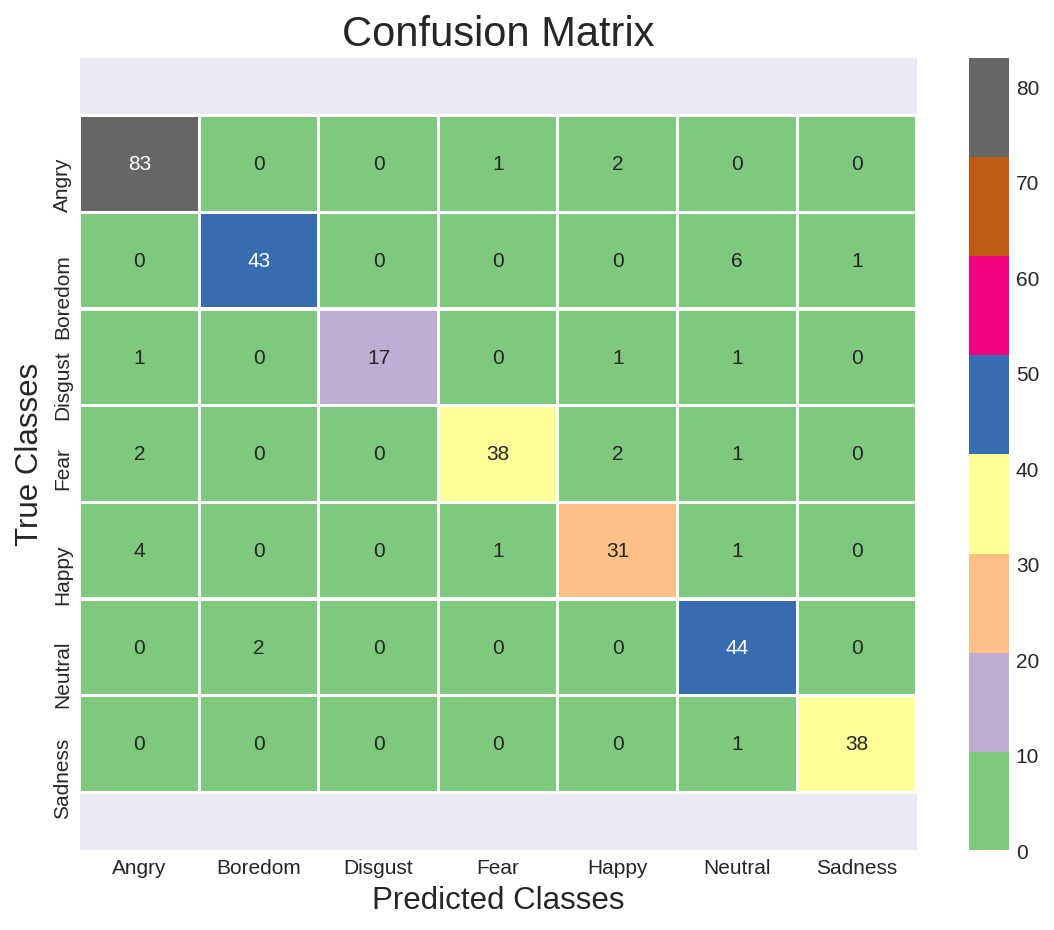

              precision    recall  f1-score   support

       Angry       0.92      0.97      0.94        86
     Boredom       0.96      0.86      0.91        50
     Disgust       1.00      0.85      0.92        20
        Fear       0.95      0.88      0.92        43
       Happy       0.86      0.84      0.85        37
     Neutral       0.81      0.96      0.88        46
     Sadness       0.97      0.97      0.97        39

    accuracy                           0.92       321
   macro avg       0.93      0.90      0.91       321
weighted avg       0.92      0.92      0.92       321



In [27]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model1.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model1.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model1.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-1.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [28]:
#MODEL-2
model2 = tf.keras.Sequential()
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model2.add(layers.MaxPooling1D(pool_size=(2)))
model2.add(BatchNormalization())
model2.add(layers.Dropout(0.25))
model2.add(layers.GRU(512))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(128, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(7, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model2.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model2.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model2.save('saved_models/model2-emo-db.hdf5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_48 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 37, 256)          

11/11 [==============================] - 0s 7ms/step - loss: 0.7312 - accuracy: 0.9097
Loss of the model is -  0.7311758995056152
11/11 [==============================] - 0s 7ms/step - loss: 0.7312 - accuracy: 0.9097
Accuracy of the model is -  90.96572995185852 %


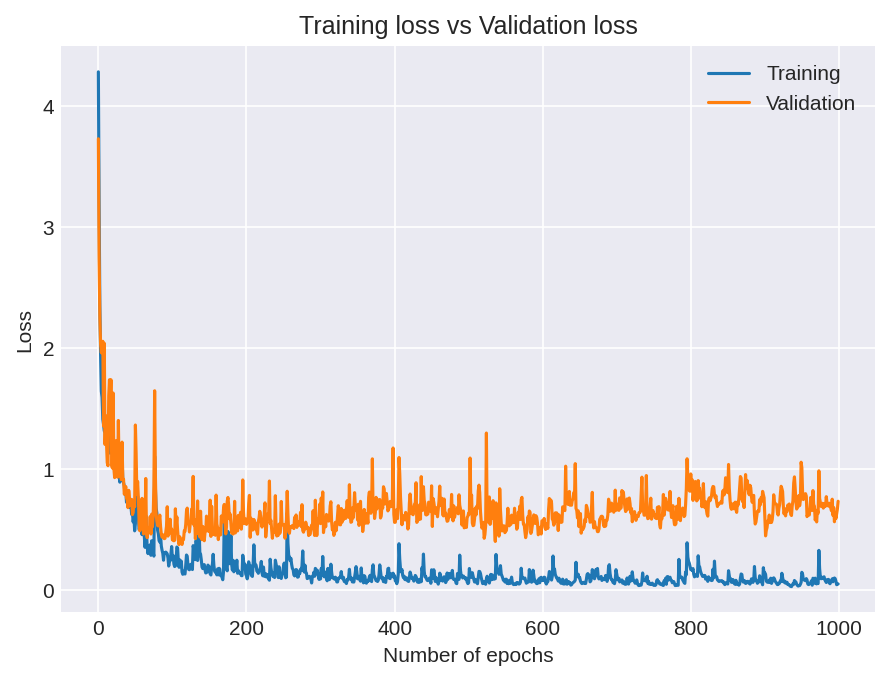

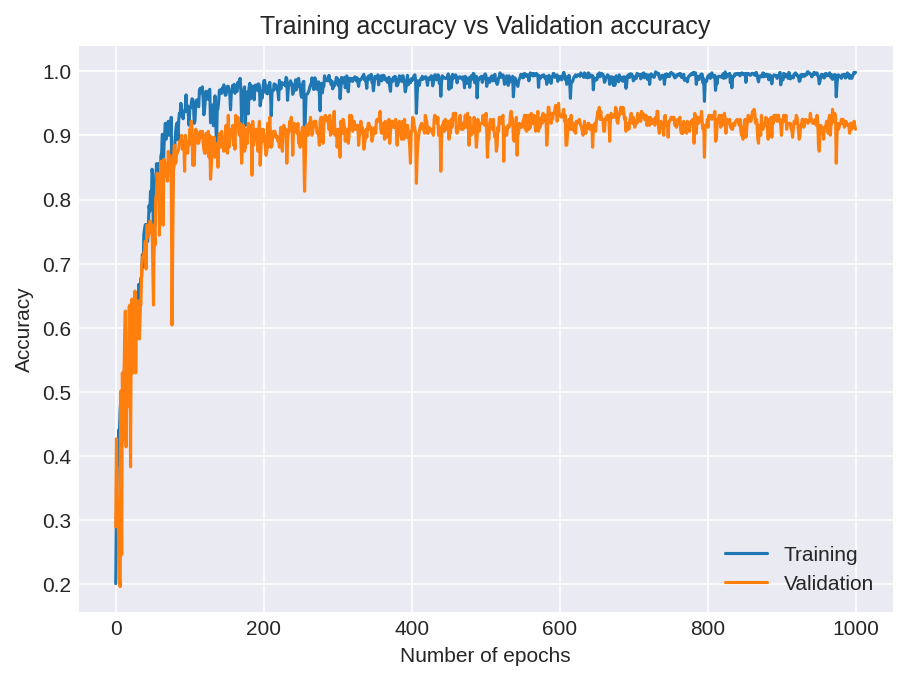

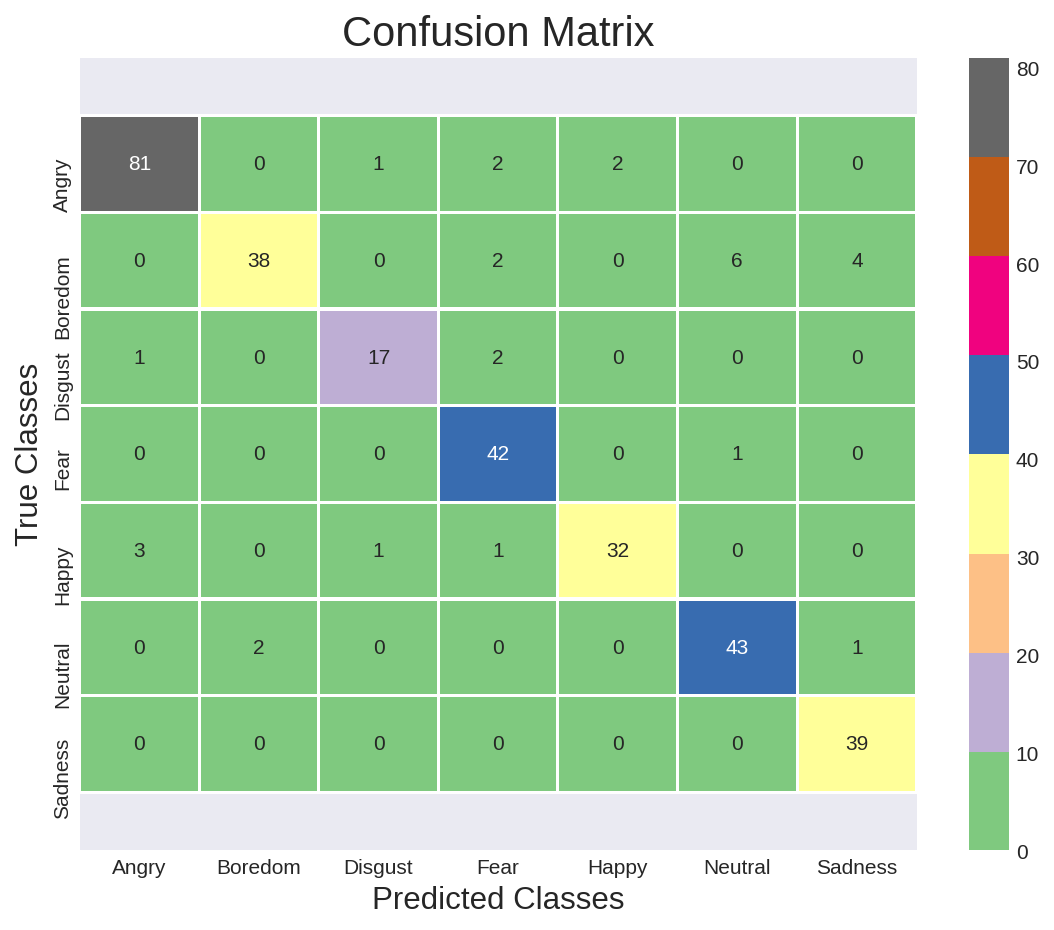

              precision    recall  f1-score   support

       Angry       0.95      0.94      0.95        86
     Boredom       0.95      0.76      0.84        50
     Disgust       0.89      0.85      0.87        20
        Fear       0.86      0.98      0.91        43
       Happy       0.94      0.86      0.90        37
     Neutral       0.86      0.93      0.90        46
     Sadness       0.89      1.00      0.94        39

    accuracy                           0.91       321
   macro avg       0.91      0.90      0.90       321
weighted avg       0.91      0.91      0.91       321



In [29]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model2.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model2.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model2.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

In [40]:
#MODEL-3
model3 = tf.keras.Sequential()
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same", activation='relu', input_shape=(x_train.shape[1],1)))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,activation='relu',dilation_rate=1,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(128, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(256, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.Conv1D(64, kernel_size=(8),strides=1,dilation_rate=1,padding="same",activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=(2)))
model3.add(BatchNormalization())
model3.add(layers.Dropout(0.25))
model3.add(layers.LSTM(512))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(64, activation='relu'))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(7, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='Adam',metrics=['accuracy'])
model3.summary()
checkpoint = ModelCheckpoint("SER_best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)
model_history=model3.fit(x_train, y_train,batch_size=32, epochs=1000, validation_data=(x_test, y_test),callbacks=[checkpoint])
model3.save('saved_models/model3-emo-db.hdf5')

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_48 (Conv1D)           (None, 155, 256)          2304      
_________________________________________________________________
conv1d_49 (Conv1D)           (None, 148, 256)          524544    
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 74, 256)           0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 74, 256)           1024      
_________________________________________________________________
dropout_58 (Dropout)         (None, 74, 256)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 74, 256)           524544    
_________________________________________________________________
max_pooling1d_43 (MaxPooling (None, 37, 256)          

11/11 [==============================] - 0s 7ms/step - loss: 0.5721 - accuracy: 0.9221
Loss of the model is -  0.5720889568328857
11/11 [==============================] - 0s 7ms/step - loss: 0.5721 - accuracy: 0.9221
Accuracy of the model is -  92.21183657646179 %


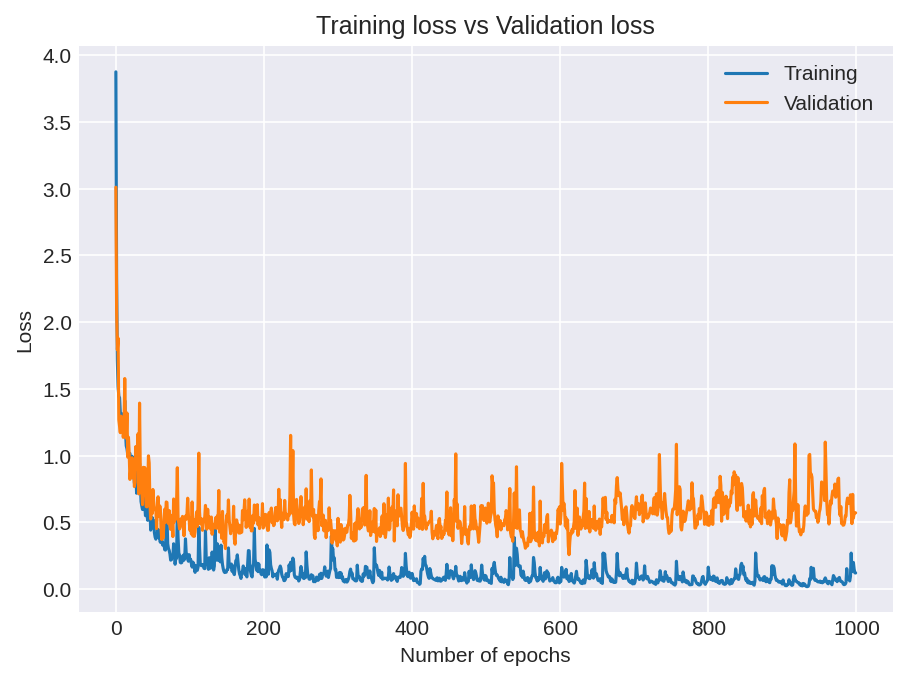

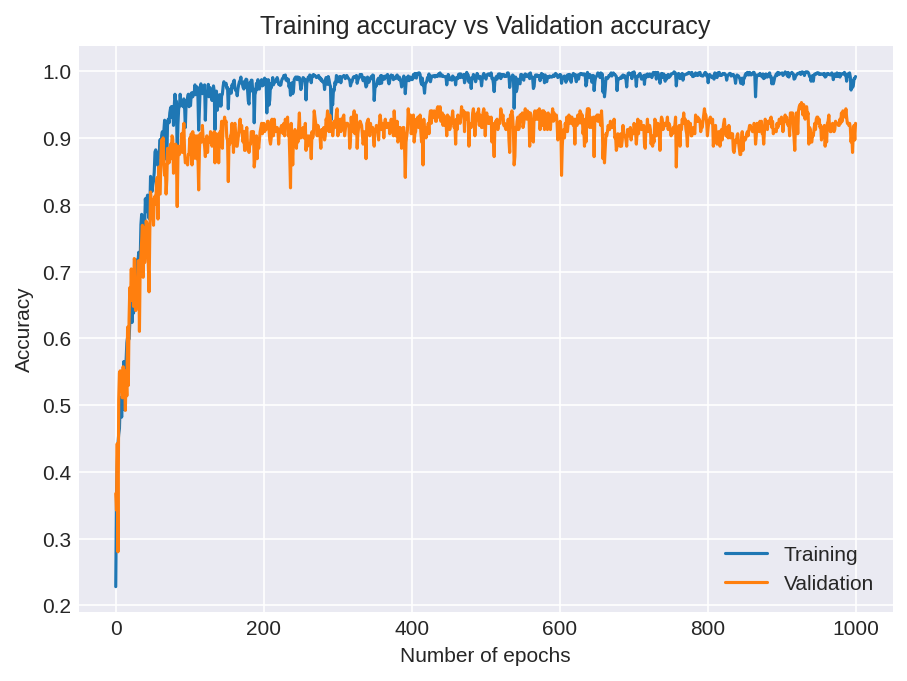

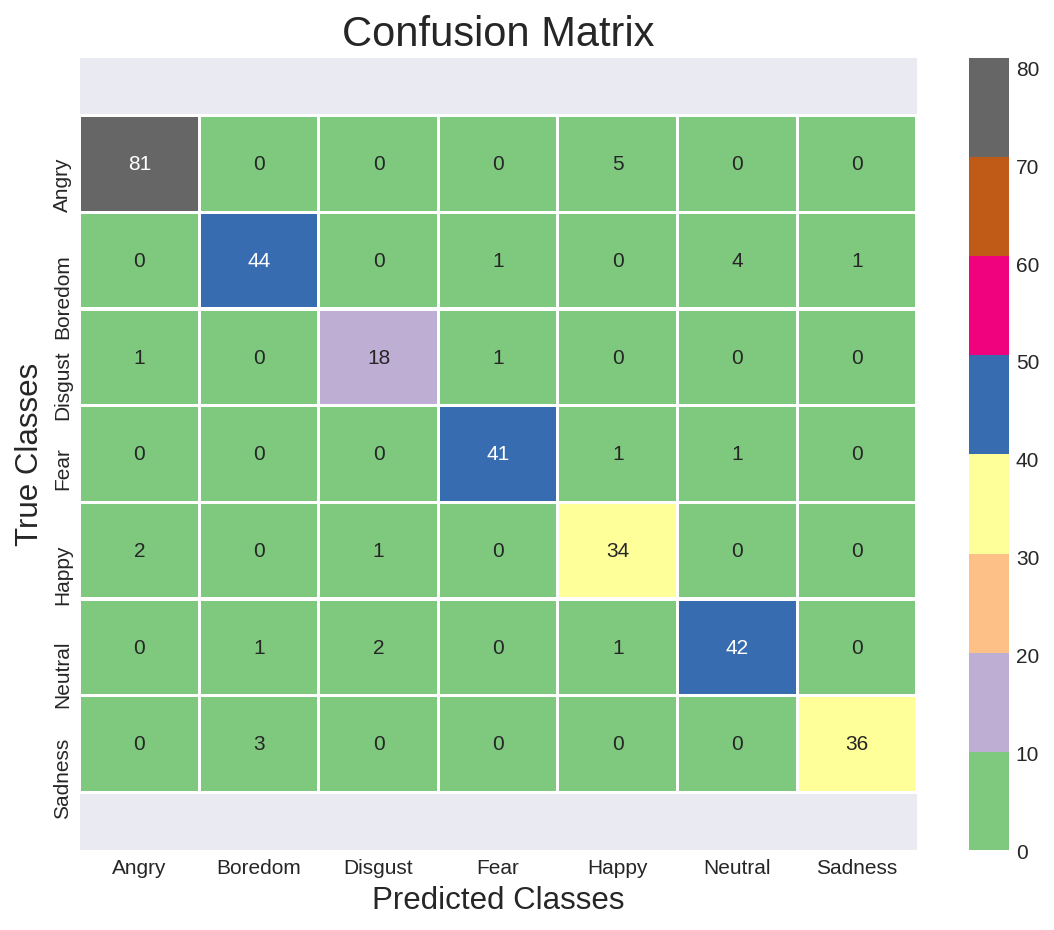

              precision    recall  f1-score   support

       Angry       0.96      0.94      0.95        86
     Boredom       0.92      0.88      0.90        50
     Disgust       0.86      0.90      0.88        20
        Fear       0.95      0.95      0.95        43
       Happy       0.83      0.92      0.87        37
     Neutral       0.89      0.91      0.90        46
     Sadness       0.97      0.92      0.95        39

    accuracy                           0.92       321
   macro avg       0.91      0.92      0.91       321
weighted avg       0.92      0.92      0.92       321



In [41]:
# PLOT MODEL HISTORY OF ACCURACY AND LOSS OVER EPOCHS
# Plot the results
train_loss=model_history.history['loss']
val_loss=model_history.history['val_loss']
train_acc=model_history.history['accuracy']
val_acc=model_history.history['val_accuracy']
plt.rcParams['figure.dpi'] = 150 
plt.figure(1,figsize=(7,5))
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.title('Training loss vs Validation loss')
plt.grid(True)
plt.legend(['Training','Validation'], loc=1)
plt.style.use(['seaborn-darkgrid'])

plt.rcParams['figure.dpi'] = 150 
plt.figure(2,figsize=(7,5))
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Training accuracy vs Validation accuracy')
plt.grid(True)
plt.legend(['Training','Validation'],loc=4)
plt.style.use(['seaborn-darkgrid'])      

# PRINT LOSS AND ACCURACY PERCENTAGE ON TEST SET
print("Loss of the model is - " , model3.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model3.evaluate(x_test,y_test)[1]*100 , "%") 

# PREDICTION LABELS
predictions = model3.predict(x_test, batch_size=32)
predictions=predictions.argmax(axis=1)
predictions
predictions = predictions.astype(int).flatten()
predictions = (lb.inverse_transform((predictions)))
predictions = pd.DataFrame({'Predicted Values': predictions}) 

# ACTUAL LABELS
TRUE = y_test.argmax(axis=1)
TRUE = TRUE.astype(int).flatten()
TRUE = (lb.inverse_transform((TRUE)))
TRUE = pd.DataFrame({'TRUE Values': TRUE})

# COMBINE PREDICTION AND ACTUAL LABELS
finaldf = TRUE.join(predictions)
finaldf[10:25] 
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(TRUE, predictions)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-3.png')
plt.show() 
from sklearn.metrics import classification_report
print(classification_report(TRUE, predictions, target_names = ['Angry', 'Boredom', 'Disgust', 'Fear', 'Happy', 'Neutral','Sadness']))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score for model1 =  0.9283489096573209
Accuracy Score for model2 =  0.9252336448598131
Accuracy Score for model3 =  0.9221183800623053
Accuracy Score for average ensemble =  0.9470404984423676
Weighted average method
Accuracy Score for model1 =  0.9283489096573209
Accuracy Score for model2 =  0.9252336448598131
Accuracy Score for model3 =  0.9221183800623053
Accuracy Score for average ensemble =  0.9470404984423676
Accuracy Score for weighted average ensemble =  0.9501557632398754
Max accuracy of  95.32710280373831  obained with w1= 0.3  w2= 0.1  and w3= 0.3


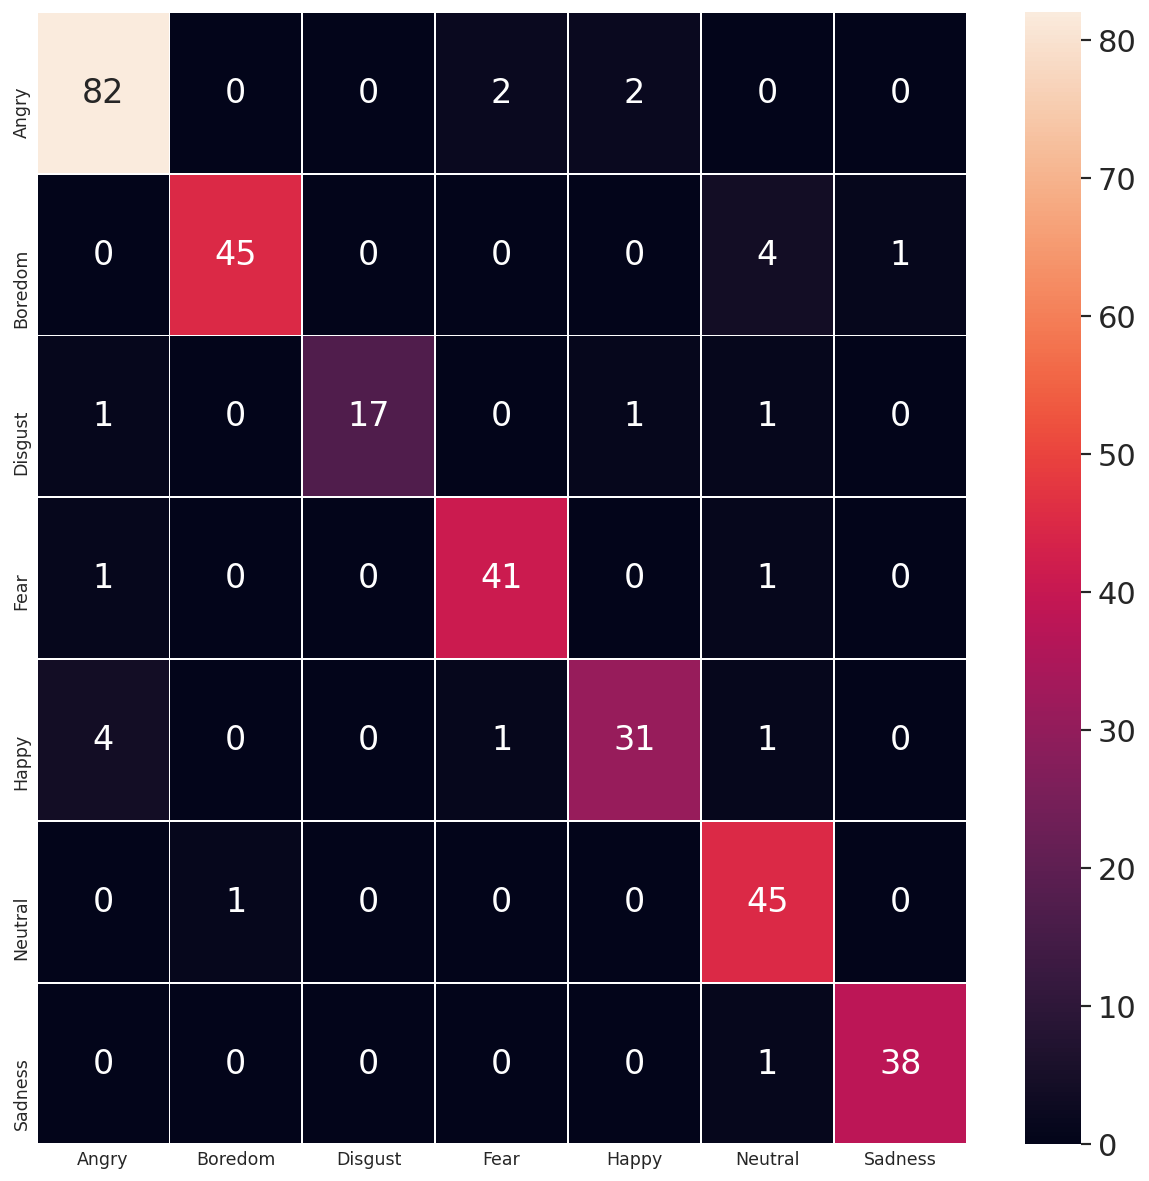

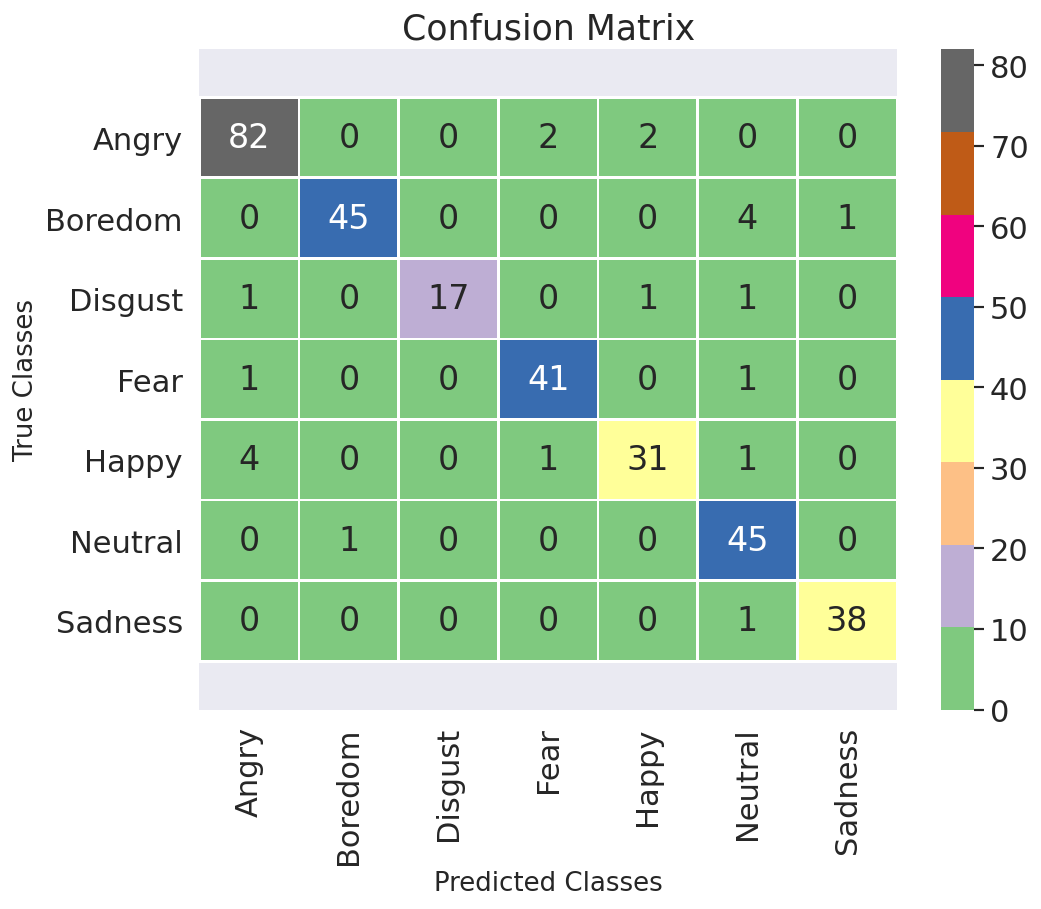

In [42]:
import random
#########################################################################
### Model average / sum Ensemble
# Simple sum of all outputs / predictions and argmax across all classes
########
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('saved_models/model1-emo-db.hdf5')
model2 = load_model('saved_models/model2-emo-db.hdf5')
model3 = load_model('saved_models/model3-emo-db.hdf5')

models = [model1, model2, model3]

preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
summed = np.sum(preds, axis=0)

# argmax across classes
ensemble_prediction = np.argmax(summed, axis=1)

prediction1 = model1.predict_classes(x_test)
prediction2 = model2.predict_classes(x_test)
prediction3 = model3.predict_classes(x_test)

accuracy1 = accuracy_score(np.argmax(y_test, axis=1), prediction1)
accuracy2 = accuracy_score(np.argmax(y_test, axis=1), prediction2)
accuracy3 = accuracy_score(np.argmax(y_test, axis=1), prediction3)
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), ensemble_prediction)

print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)

########################################
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.4, 0.2, 0.4]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)

########################################
#Grid search for the best combination of w1, w2, w3 that gives maximum acuracy
models = [model1, model2, model3]
preds1 = [model.predict(x_test) for model in models]
preds1=np.array(preds1)

import pandas as pd
df = pd.DataFrame([])

for w1 in range(0, 5):
    for w2 in range(0,5):
        for w3 in range(0,5):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds1 = np.tensordot(preds1, wts, axes=((0),(0)))
            wted_ensemble_pred = np.argmax(wted_preds1, axis=1)
            weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), wted_ensemble_pred)
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'acc':weighted_accuracy*100}, index=[0]), ignore_index=True)
            
max_acc_row = df.iloc[df['acc'].idxmax()]
print("Max accuracy of ", max_acc_row[3], " obained with w1=", max_acc_row[0],
      " w2=", max_acc_row[1], " and w3=", max_acc_row[2])         




###########################################################################
### Explore metrics for the ideal weighted ensemble model. 

models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
ideal_weights = [0.4, 0.1, 0.2] 

#Use tensordot to sum the products of all elements over specified axes.
ideal_weighted_preds = np.tensordot(preds, ideal_weights, axes=((0),(0)))
ideal_weighted_ensemble_prediction = np.argmax(ideal_weighted_preds, axis=1)

ideal_weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)



from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('emo-db-model-2.png')
plt.show() 

Weighted average method
Accuracy Score for model1 =  0.9283489096573209
Accuracy Score for model2 =  0.9252336448598131
Accuracy Score for model3 =  0.9221183800623053
Accuracy Score for average ensemble =  0.9470404984423676
Accuracy Score for weighted average ensemble =  0.9532710280373832


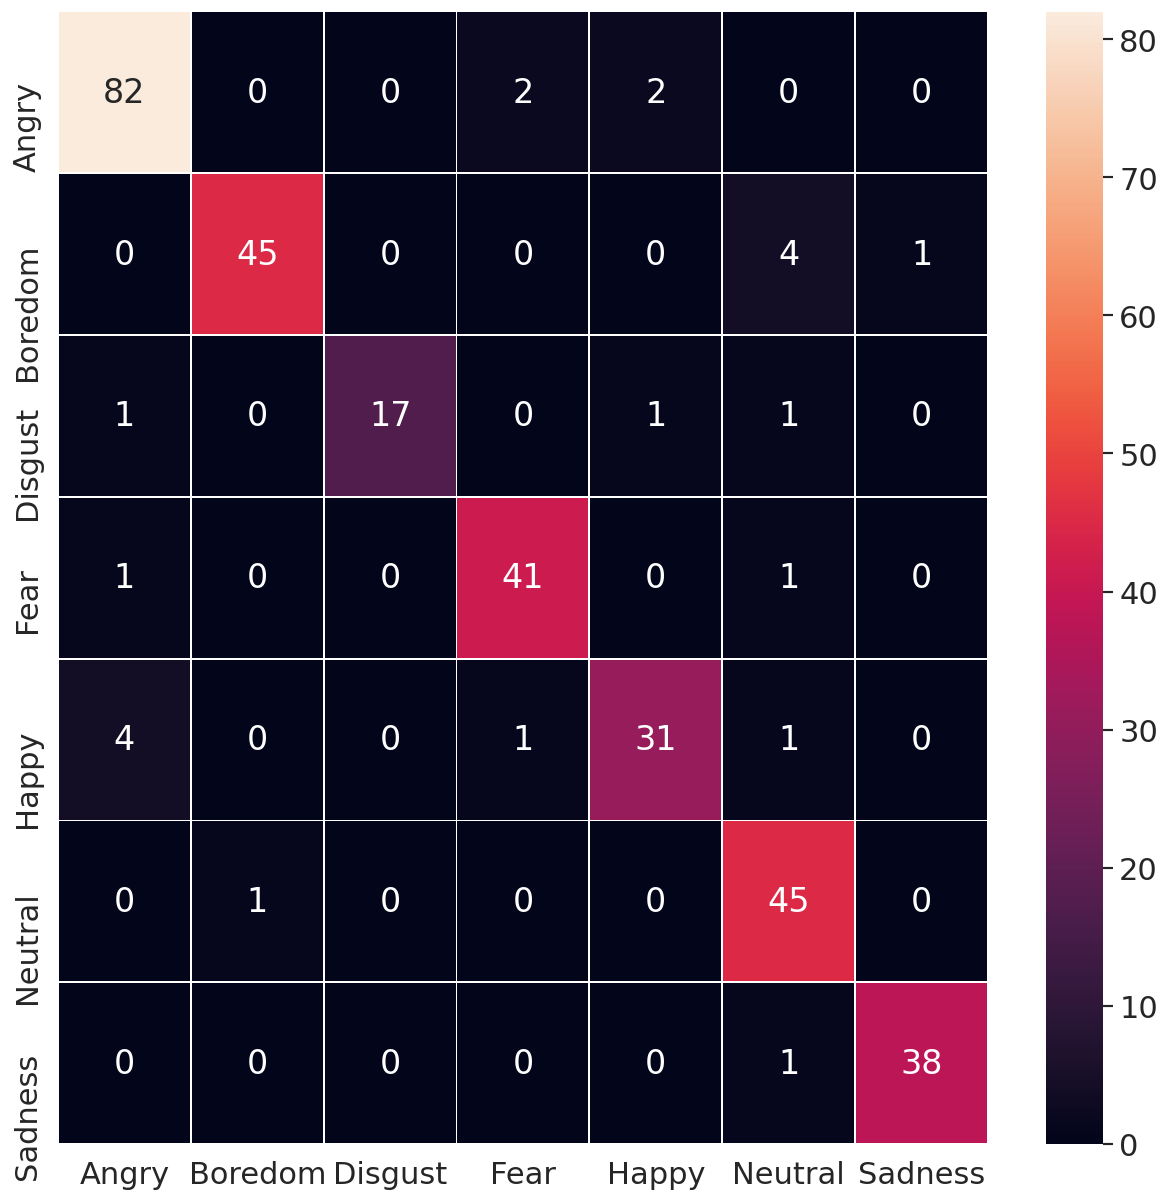

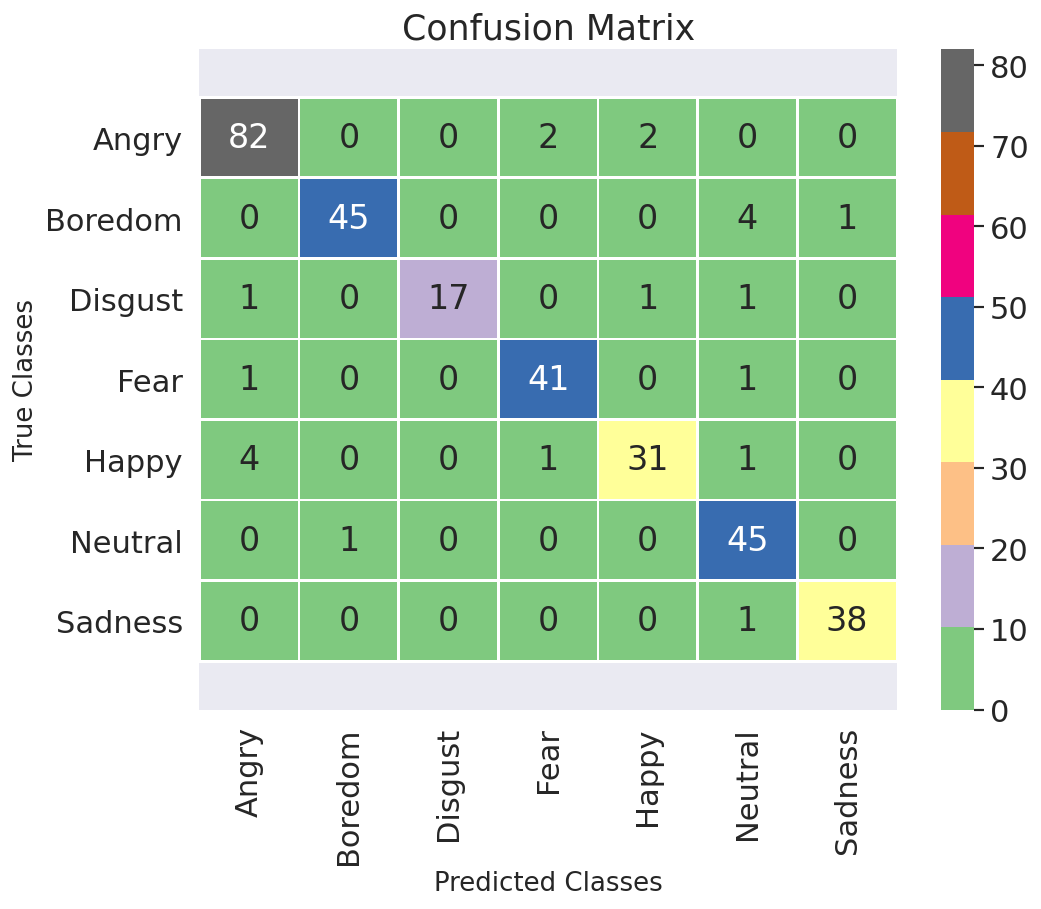

In [43]:
#Weighted average ensemble
models = [model1, model2, model3]
preds = [model.predict(x_test) for model in models]
preds=np.array(preds)
weights = [0.3, 0.1, 0.3]

#Use tensordot to sum the products of all elements over specified axes.
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.argmax(weighted_preds, axis=1)

weighted_accuracy = accuracy_score(np.argmax(y_test, axis=1), weighted_ensemble_prediction)
print('Weighted average method')
print('Accuracy Score for model1 = ', accuracy1)
print('Accuracy Score for model2 = ', accuracy2)
print('Accuracy Score for model3 = ', accuracy3)
print('Accuracy Score for average ensemble = ', ensemble_accuracy)
print('Accuracy Score for weighted average ensemble = ', weighted_accuracy)


from sklearn.metrics import confusion_matrix
import seaborn as sns
#Print confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])

fig, ax = plt.subplots(figsize=(12,12))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION -SGD-MFCC
cm = confusion_matrix(np.argmax(y_test, axis=1), ideal_weighted_ensemble_prediction)
plt.figure(figsize = (9,7))
plt.rcParams['figure.dpi'] = 125 
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
ax = sns.heatmap(cm, linecolor='white', cmap='Accent', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.6, top - 0.6)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Classes', size=15)
plt.ylabel('True Classes', size=15)
plt.savefig('SAVEE-EMSEMBLE.png')
plt.show() 